In [1]:
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.multioutput import MultiOutputRegressor

### Helper Functions

In [2]:
def loadData(file):
    data = pd.read_csv(file)
    print('Raw shape: ',data.shape)
    data['Date'] = pd.to_datetime(data.Date)
    print('Days: ',len(set(data.Date)))
    return data

In [3]:
def getTimeSeries(df):
    table = pd.pivot_table(df, values='vehicle_count', index=['Date','Hour'],
                    columns=['DOLocationID'], aggfunc=np.sum, fill_value=0)
    return table

In [4]:
def zscoreNormalizeSpatial(matrix):
    m = matrix.copy()
    for i in range(m.shape[0]):
        m[i, :] = (m[i, :] - m[i, :].mean()) / (m[i, :].std()+1e-10)
        
    return m

In [5]:
def standardize(matrix):
    m = matrix.copy()
    scaler = StandardScaler()
    scaler.fit(m)
    t = scaler.transform(m)
    return scaler, t

In [6]:
def inverse_standardize(matrix, scaler):
    t = matrix.copy()
    return scaler.inverse_transform(t)

In [7]:
def getPCAFeatures(matrix, n=10):
    pca = PCA(n_components=n)
    pca.fit(matrix)
    reducedMatrixPCA = pca.transform(matrix)
    reducedMatrixPCA.shape

    reducedDict = {str(i+1):reducedMatrixPCA[:,i] for i in range(reducedMatrixPCA.shape[1])}
    reducedDf = pd.DataFrame(reducedDict)
    #reducedDf.index = index
    return pca,reducedDf

In [8]:
def PCA_test(matrix, pca):

    reducedMatrixPCA = pca.transform(matrix)

    reducedDict = {str(i+1):reducedMatrixPCA[:,i] for i in range(reducedMatrixPCA.shape[1])}
    reducedDf = pd.DataFrame(reducedDict)
    #reducedDf.index = index
    return reducedDf

In [9]:
def inverse_pca(matrix,pca):
    m = matrix.copy()
    return pca.inverse_transform(m)

In [10]:
def addLag(dataset, maxlag):
    dataset_list = [dataset]

    for l in range(1, maxlag+1):
        df = dataset.shift(l)
        df.columns = [c+'_lag_'+str(l) for c in df.columns]
        dataset_list.append(df)

    dataset = pd.concat(dataset_list, axis=1).dropna()
    return dataset

In [11]:
def get_rmse(matrix1, matrix2):
    sumSquareError = np.mean(np.power(matrix1 - matrix2,2))
    rmse = np.power(sumSquareError,0.5)
    return rmse

In [67]:
def pca_performance(trainmatrix,testmatrix, components):
    rmseList = []
    r2List = []
    for n in components:
        scaler, s_train_matrix = standardize(trainmatrix)
        s_test_matrix = scaler.transform(testmatrix)

        pca,pcaTrain = getPCAFeatures(s_train_matrix,n=n)
        pcaTest = PCA_test(s_test_matrix, pca)
        
        network_prediction = inverse_pca(pcaTest,pca)
        network_prediction = inverse_standardize(network_prediction, scaler)

        r2Score = r2_score(testmatrix, network_prediction, multioutput='variance_weighted')
                
        r2List.append(r2Score)
    
    return r2List

In [104]:
def nonlinearperformance(trainmatrix,testmatrix,components, maxlag=12):
    r2List = []
    for n in components:
        print(n)
        scaler, s_train_matrix = standardize(trainmatrix)
        s_test_matrix = scaler.transform(testmatrix)

        pca,pcaTrain = getPCAFeatures(s_train_matrix,n=n)
        pcaTest = PCA_test(s_test_matrix, pca)

#         maxlag = 12
        DateColumns = ['Date', 'Hour']
        lagColumns = [c for c in pcaTrain.columns if c not in DateColumns]

        dataset_train = addLag(pcaTrain, maxlag)

        dataset_test = addLag(pcaTest, maxlag)

        X_train = dataset_train.drop(lagColumns , axis = 1)
        X_test = dataset_test.drop(lagColumns , axis = 1)
        y_train = dataset_train[lagColumns]
        y_test = dataset_test[lagColumns]
#         print(X_train.shape)
#         print(X_test.shape)
#         print(y_train.shape)
#         print(y_test.shape)

        rf2 = RandomForestRegressor(random_state = 0, n_estimators=200, 
                                   min_samples_split=10,
                                   min_samples_leaf= 3, 
                                   max_features= 'sqrt',
                                   max_depth= 30, 
                                   bootstrap= True)

        rf2.fit(X_train,y_train)

        pca_prediction = rf2.predict(X_test)

        network_prediction = inverse_pca(pca_prediction,pca)

        network_prediction = inverse_standardize(network_prediction, scaler)

        r2Score = r2_score(testmatrix[maxlag:], network_prediction, \
                           multioutput='variance_weighted')
        
        r2List.append(r2Score)
    return r2List

#### Preparing Data

In [51]:
file = '/home/urwa/Documents/Projects/NYU Remote/project/data/JfkVehiceByHour.csv'

In [52]:
data = loadData(file)

Raw shape:  (4520160, 4)
Days:  730


In [53]:
data = getTimeSeries(data)

In [54]:
data.shape

(17520, 258)

### Train test Split

In [55]:
sep = int(0.8*len(data))
sep

14016

In [56]:
trainData = data[:sep]
testData = data[sep:]

In [57]:
trainData.shape

(14016, 258)

In [58]:
testData.shape

(3504, 258)

In [59]:
trainmatrix = trainData.values.astype(np.float64)
testmatrix = testData.values.astype(np.float64)

### PCA component selection

In [81]:
component = list(range(5,55,10))

In [82]:
pca_r2 = pca_performance(trainmatrix,testmatrix, component)

In [83]:
model_r2 = nonlinearperformance(trainmatrix,testmatrix, component)

5
15
25
35
45


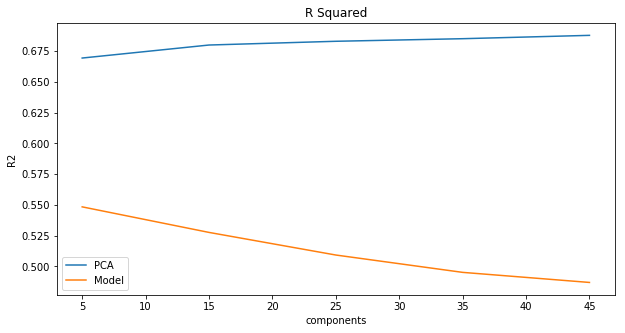

In [109]:
plt.figure(figsize=(10,5))
plt.title('R Squared')
plt.xlabel('components')
plt.ylabel('R2')
plt.plot(component,pca_r2, label='PCA')
plt.plot(component,model_r2, label='Model')
plt.legend()

### Max Lag Selection

In [105]:
maxLagList = [4,8,12,16]
maxLag_r2 = [nonlinearperformance(trainmatrix,testmatrix,[5], m)[0] for m in maxLagList]

5
5
5
5


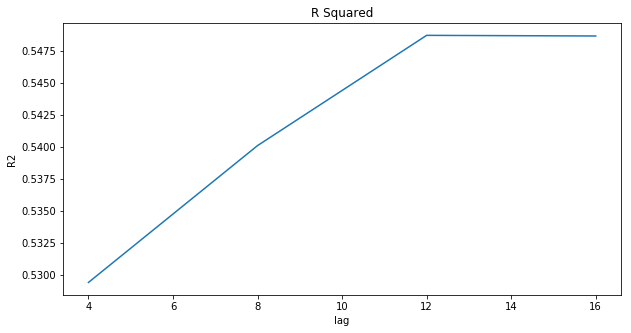

In [106]:
plt.figure(figsize=(10,5))
plt.title('R Squared')
plt.xlabel('lag')
plt.ylabel('R2')
plt.plot(maxLagList,maxLag_r2)

### Best Model Training

### Normalization

In [85]:
scaler, s_train_matrix = standardize(trainmatrix)
s_test_matrix = scaler.transform(testmatrix)

## PCA

In [86]:
pca,pcaTrain = getPCAFeatures(s_train_matrix,n=5)
pcaTest = PCA_test(s_test_matrix, pca)

In [87]:
pcaTrain.shape, pcaTest.shape

((14016, 5), (3504, 5))

In [88]:
pcaTrain.head(3)

,1,2,3,4,5
0,-5.343973,3.997723,0.678724,-0.220780,0.228468
1,-9.769835,1.061748,1.704459,0.181815,-0.164243
2,-11.843036,0.896696,1.072943,-0.340779,0.282427


### Lag Variables

In [89]:
maxlag = 12
DateColumns = ['Date', 'Hour']
lagColumns = [c for c in pcaTrain.columns if c not in DateColumns]

dataset_train = addLag(pcaTrain, maxlag)

dataset_train.shape

(14004, 65)

In [90]:
dataset_test = addLag(pcaTest, maxlag)
dataset_test.shape

(3492, 65)

### Modelling

In [91]:
X_train = dataset_train.drop(lagColumns , axis = 1)
X_test = dataset_test.drop(lagColumns , axis = 1)
y_train = dataset_train[lagColumns]
y_test = dataset_test[lagColumns]

In [92]:
X_train.shape, X_test.shape

((14004, 60), (3492, 60))

In [93]:
y_train.shape, y_test.shape

((14004, 5), (3492, 5))

In [94]:
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3)

In [95]:
rf2 = RandomForestRegressor(random_state = 0, n_estimators=200, 
                           min_samples_split=10,
                           min_samples_leaf= 3, 
                           max_features= 'sqrt',
                           max_depth= 30, 
                           bootstrap= True)

In [96]:
rf2.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [97]:
rf2.score(X_train,y_train)

0.9114836814837145

In [98]:
rf2.score(X_test,y_test)

0.7689216399329399

### Predict

In [99]:
pca_prediction = rf2.predict(X_test)
pca_prediction.shape

(3492, 5)

In [100]:
network_prediction = inverse_pca(pca_prediction,pca)
network_prediction.shape

(3492, 258)

In [101]:
network_prediction = inverse_standardize(network_prediction, scaler)
network_prediction.shape

(3492, 258)

### Evaluate

In [102]:
get_rmse(testmatrix[maxlag:], network_prediction)

1.933450376661542

In [103]:
r2_score(testmatrix[maxlag:], network_prediction, multioutput='variance_weighted')

0.5487933776405783